In [1]:
import numpy as np
import scipy.fftpack
from scipy import ndimage
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import math
import sys
import os

Data load

In [2]:
data=pd.read_table('datos.txt')
data_2=(data.round(2)).pivot(index='Y', columns='X', values='RV')

In [24]:
nom_reg = '604'
nom_lin = 'Halpha'
pc=4.16

In [3]:
data.describe()

,X,Y,RV
count,330.000000,330.000000,330.000000
mean,107.280000,9.390000,-275.757688
std,12.788265,6.260324,9.697986
min,85.824000,0.000000,-296.649181
25%,96.552000,4.000000,-282.613847
50%,107.280000,9.000000,-276.070115
75%,118.008000,15.000000,-270.394313
max,128.736000,19.600000,-231.143341


(0.0, 33.0, 0.0, 10.0)

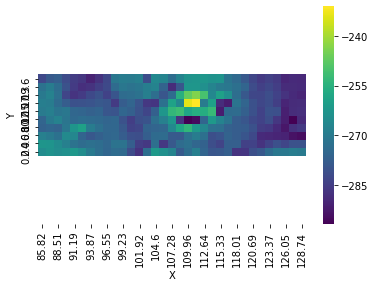

In [4]:
sns.heatmap(data_2, cmap="viridis")
plt.gca().invert_yaxis()
plt.axis('equal')

Energy Spectrum
$$E(k) \propto k^{-\beta}$$
Turbulent case
$$\beta = -5 / 3,-2$$
Energy-Power Spectrum relation
$$E(k) \propto k^{N-1} P(k)$$
where it is fulfiled
$$P(k)\propto k^{-\gamma}$$

Fourier Transform 2D

In [5]:
#Return multidimensional discrete Fourier transform.
FT2a=scipy.fftpack.fft2(data_2)
#Shift the zero-frequency component to the center of the spectrum.
FT2 = scipy.fftpack.fftshift(FT2a)
power_s = np.abs(FT2)

(0.0, 33.0, 0.0, 10.0)

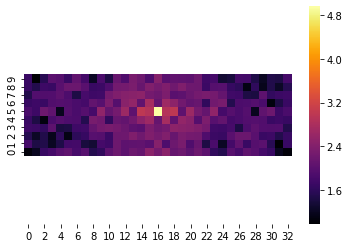

In [6]:
sns.heatmap(np.log10(power_s), cmap="inferno")
plt.gca().invert_yaxis()
plt.axis('equal')

PSD1D
https://medium.com/tangibit-studios/2d-spectrum-characterization-e288f255cc59


In [7]:
h  = power_s.shape[0]
w  = power_s.shape[1]
wc = w//2
hc = h//2

# create an array of integer radial distances from the center
Y, X = np.ogrid[0:h, 0:w]
r    = np.hypot(X - wc, Y - hc).astype(np.int)
rdf=pd.DataFrame(r)

(0.0, 33.0, 0.0, 10.0)

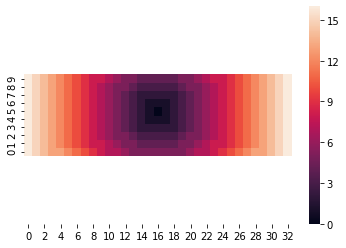

In [8]:
sns.heatmap(rdf)
plt.gca().invert_yaxis()
plt.axis('equal')

In [9]:
# SUM all psd2D pixels with label 'r' for 0<=r<=wc
psd1D_1= ndimage.sum(power_s, r, index=np.arange(0, wc+1))
psd1D_1

array([91000.01      ,  3967.5307509 ,  4825.6521439 ,  4089.13884688,
        4951.6560172 ,  5427.48287182,  2625.79168573,  2679.5785896 ,
        1877.77752426,  1186.73794389,  1542.8536051 ,  1410.06073371,
        1436.9772572 ,  1645.90588453,  1093.0009225 ,   773.67779786,
         951.9044606 ])

Out of the black-box method

In [10]:
psdf=pd.DataFrame(power_s)
data_ps=dict()

In [11]:
for i in range(wc+1):
    m=(rdf==i)
    psm=(psdf[m].fillna(0)).to_numpy()
    s=psm.sum()
    err=psm.std()/np.sqrt(len(psm)-1)
    data_ps[i]=[i,s,err]
    
psd1D_2=pd.DataFrame(data_ps).T

In [12]:
psd1D_2.head()

,0,1,2
0,0.0,91000.010000,1667.263315
1,1.0,3967.530751,28.312414
2,2.0,4825.652144,29.492494
3,3.0,4089.138847,17.519286
4,4.0,4951.656017,20.128097


In [13]:
Err_12=psd1D_1-psd1D_2[1]
Err_12.sum()

-1.2505552149377763e-12

Text(0, 0.5, '$ \\mathrm{P(k)},\\ \\mathrm{km^2\\ s^{-2}}$')

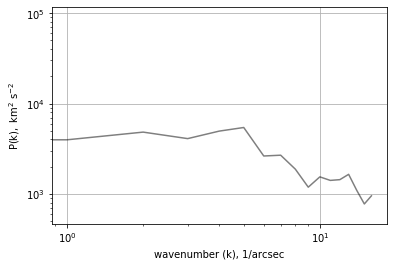

In [39]:
plt.loglog(psd1D_1, color='k', alpha=0.5)
plt.ylim(psd1D_2[1].min()*0.6, psd1D_2[1].max()*1.3)
plt.grid()
plt.xlabel('wavenumber (k), 1/arcsec')
plt.ylabel(r'$ \mathrm{P(k)},\ \mathrm{km^2\ s^{-2}}$')

[Text(0, 0.5, '$ \\mathrm{P(k)},\\ \\mathrm{km^2\\ s^{-2}}$'),
 Text(0.5, 0, 'wavenumber (k), 1/arcsec')]

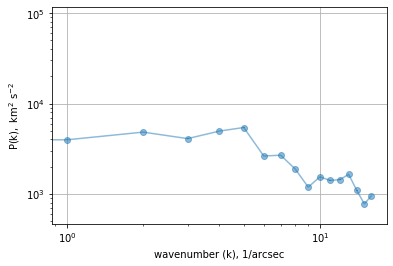

In [27]:
fig, ax=plt.subplots()
sgrid = np.logspace(0.5, 1.2)
#plt.plot(sgrid, (10**7)*sgrid**(-11/3), color="k", lw=1, label="Kolmogorov")
#plt.plot(sgrid, (10**5.1)*sgrid**(-2), color="r", lw=1, label="Burgers")
ax.errorbar(psd1D_2[0],psd1D_2[1],yerr=psd1D_2[2], fmt="o-", ecolor='k', alpha=0.5)
ax.set(xscale='log',yscale='log')
#plt.legend()
#plt.xlim(2, 20)
plt.ylim(psd1D_2[1].min()*0.6, psd1D_2[1].max()*1.3)
ax.grid()
ax.set(xlabel='wavenumber (k), 1/arcsec', ylabel=r'$ \mathrm{P(k)},\ \mathrm{km^2\ s^{-2}}$')